In [119]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import style
import warnings
from datetime import datetime
import time
# style.use('fivethirtyeight')
style.use('seaborn')
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('data/train_users_2.csv')
test_df = pd.read_csv('data/test_users.csv')
sessions = pd.read_csv('data/sessions.csv')
countries = pd.read_csv('data/countries.csv')
age_gender = pd.read_csv('data/age_gender_bkts.csv')

## Helper func 

In [104]:
def age_correct(x):
    if x > 1000:
        return 2015-x 
    else:
        return x

In [105]:
def age_bin(x):
    if 0<x<=30:
        return '0-30'
    elif 30<x<=60:
        return '30-60'
    elif x>60:
        return '60-100'
    else:
        return np.nan

In [142]:
def date_correct(x):
    str_date = str(x)
    str_datetime = str_date[0:4]+'-'+str_date[4:6]+'-'+str_date[6:8]
    return datetime.strptime(str_datetime, "%Y-%m-%d")

## Basic Infos

In [3]:
# for df in [train_df, sessions, countries, age_gender]:
#     print(df.info())
#     print('-'*50)

In [4]:
# for df in [train_df, sessions, countries, age_gender]:
#     print(df.describe())
#     print('-'*50)

## EDA
1. train_df 
2. age_gender

In [5]:
train_df.head(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US


### 確認target 是否有data imbalance問題
1. 6成NDF，3成US
2. Evaluation metrics：NDCG
3. data imbalance 問題

In [6]:
print('目的地占比 %')
(train_df.iloc[:, -1].value_counts()/len(train_df))*100

目的地占比 %


NDF      58.347349
US       29.222632
other     4.728954
FR        2.353233
IT        1.328174
GB        1.088774
ES        1.053638
CA        0.669006
DE        0.497070
NL        0.356991
AU        0.252517
PT        0.101663
Name: country_destination, dtype: float64

In [7]:
sessions.head(3)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0


In [8]:
countries.head(3)

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61


In [9]:
age_gender

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0
...,...,...,...,...,...
415,95-99,US,male,115.0,2015.0
416,90-94,US,male,541.0,2015.0
417,15-19,US,female,10570.0,2015.0
418,85-89,US,male,1441.0,2015.0


### date_first_booking 缺值 -> NDF, 沒缺 -> 沒有NDF

In [10]:
train_df[train_df['date_first_booking'].isnull()]['country_destination'].value_counts()

NDF    124543
Name: country_destination, dtype: int64

In [11]:
train_df[train_df['date_first_booking'].notnull()]['country_destination'].value_counts()

US       62376
other    10094
FR        5023
IT        2835
GB        2324
ES        2249
CA        1428
DE        1061
NL         762
AU         539
PT         217
Name: country_destination, dtype: int64

In [12]:
new_df = train_df[train_df['date_first_booking'].notnull()]

## 類別 vs 類別
The df.plot() function returns a matplotlib.axes.AxesSubplot object

In [13]:
cat_cols = train_df.select_dtypes(include='object').columns[3:-1]
print(f'column length: {len(cat_cols)}')

column length: 9


In [14]:
# fig, axes = plt.subplots(nrows=3, ncols=3, figsize= (20,12))

# for i, col in enumerate(cat_cols):
#     df = (train_df.groupby(['country_destination'])[col].value_counts()/train_df.groupby(['country_destination']).size()).unstack()
#     df.plot(kind= 'bar', ax= axes[int(i/3), (i%3)])
    
# plt.tight_layout()
# plt.show()

In [15]:
# for i, col in enumerate(cat_cols):
#     plt.figure(figsize=(20,20))
#     ax = (train_df.groupby(['country_destination'])[col].value_counts()/train_df.groupby(['country_destination']).size()).unstack().plot(kind= 'bar')
#     ax.set_xlabel('target destination')
#     ax.set_ylabel('percentage')
#     ax.set_title('hist')
#     plt.show()

### 語言和target有關係

In [16]:
(new_df.groupby(['language'])['country_destination'].value_counts()*100/new_df.groupby(['language']).size()).round(1).unstack()

country_destination,AU,CA,DE,ES,FR,GB,IT,NL,PT,US,other
language,,,,,,,,,,,
ca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN
cs,NaN,NaN,NaN,11.1,NaN,NaN,NaN,NaN,NaN,66.7,22.2
da,NaN,NaN,NaN,10.5,NaN,NaN,5.3,NaN,NaN,73.7,10.5
de,1.1,0.4,8.9,2.6,3.7,1.9,2.2,0.7,0.4,71.5,6.7
el,NaN,NaN,NaN,33.3,16.7,NaN,NaN,NaN,NaN,33.3,16.7
en,0.6,1.6,1.2,2.5,5.6,2.6,3.2,0.9,0.2,70.2,11.3
es,NaN,NaN,2.2,7.3,6.5,2.2,3.3,0.4,0.7,60.4,17.1
fi,NaN,NaN,NaN,NaN,14.3,NaN,NaN,NaN,NaN,71.4,14.3
fr,0.5,1.8,2.0,2.8,17.3,3.0,2.8,1.0,0.5,63.7,4.8


### 性別對target影響差異不大

In [17]:
(new_df.groupby(['gender'])['country_destination'].value_counts()*100/new_df.groupby(['gender']).size()).round(1).unstack()

country_destination,AU,CA,DE,ES,FR,GB,IT,NL,PT,US,other
gender,,,,,,,,,,,
-unknown-,0.5,1.7,1.0,2.5,5.9,2.6,3.6,0.8,0.2,69.3,12.0
FEMALE,0.6,1.4,1.1,2.7,6.1,2.8,3.4,0.8,0.2,70.9,9.9
MALE,0.7,1.7,1.5,2.4,4.8,2.5,2.5,1.0,0.2,70.2,12.4
OTHER,0.6,2.8,1.7,2.3,7.4,1.7,2.8,1.7,0.6,65.9,12.5


In [18]:
(new_df.groupby(['country_destination'])['gender'].value_counts()*100/new_df.groupby(['country_destination']).size()).round(1).unstack()

gender,-unknown-,FEMALE,MALE,OTHER
country_destination,,,,
AU,26.5,38.4,34.9,0.2
CA,34.4,31.9,33.4,0.4
DE,26.8,33.7,39.2,0.3
ES,31.8,37.9,30.1,0.2
FR,34.1,39.1,26.6,0.3
GB,32.6,37.9,29.3,0.1
IT,36.7,38.5,24.7,0.2
NL,29.8,33.3,36.5,0.4
PT,31.8,35.9,31.8,0.5


## 連續 vs 類別
age 要clean

In [19]:
new_df['age'].describe()

count    68532.000000
mean        47.872629
std        146.042716
min          2.000000
25%         28.000000
50%         33.000000
75%         42.000000
max       2014.000000
Name: age, dtype: float64

In [21]:
new_df['age_clean'] = new_df['age'].apply(age_correct)

Text(0, 0.5, 'age')

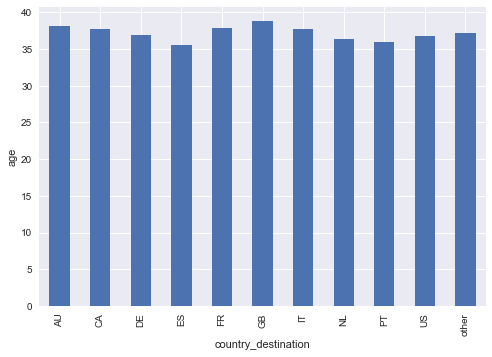

In [22]:
ax = new_df.groupby(['country_destination'])['age_clean'].mean().plot(kind='bar')
ax.set_ylabel('age')
# ax.set_xticklabels(train_df.groupby(['country_destination'])['age'].mean().keys())

In [24]:
new_df['age_bin'] = new_df['age_clean'].apply(age_bin)

<AxesSubplot:xlabel='age_bin'>

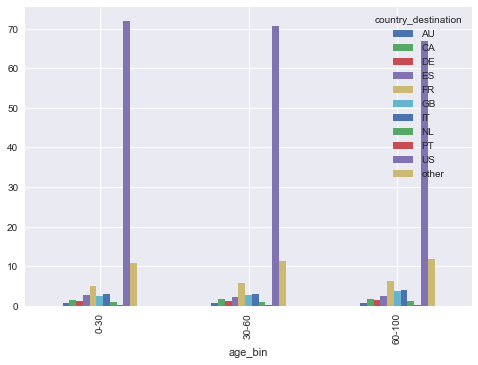

In [25]:
(new_df.groupby(['age_bin'])['country_destination'].value_counts()*100/new_df.groupby(['age_bin']).size()).unstack().plot(kind='bar')

### signup_flow
signup_flow有影響

In [26]:
(new_df.groupby(['signup_flow'])['country_destination'].value_counts()*100/new_df.groupby(['signup_flow']).size()).round(1).unstack()

country_destination,AU,CA,DE,ES,FR,GB,IT,NL,PT,US,other
signup_flow,,,,,,,,,,,
0,0.6,1.6,1.2,2.5,5.8,2.7,3.3,0.9,0.3,69.5,11.6
1,0.6,3.0,0.6,3.0,2.4,1.8,3.6,2.4,NaN,71.6,11.2
2,0.7,2.4,1.5,2.9,7.3,2.1,3.2,1.0,0.2,71.4,7.5
3,0.5,1.8,1.4,3.1,6.4,2.7,3.6,0.9,0.2,69.4,10.1
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN
6,0.6,1.2,NaN,4.9,7.9,1.8,1.8,2.4,1.2,66.5,11.6
8,0.9,2.7,3.6,7.2,6.3,2.7,11.7,3.6,0.9,45.0,15.3
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN
12,0.6,1.0,0.8,2.0,3.1,2.1,1.8,0.7,0.1,76.6,11.3


## age_gender 

In [27]:
age_gender.head(3)

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0


### gender

In [28]:
(age_gender.groupby(['gender', 'country_destination'])['population_in_thousands'].sum()*100/age_gender.groupby(['gender'])['population_in_thousands'].sum()).unstack()

country_destination,AU,CA,DE,ES,FR,GB,IT,NL,PT,US
gender,,,,,,,,,,
female,3.230460,4.853751,11.283238,6.413098,8.998487,8.690057,8.437509,2.279914,1.469075,44.344411
male,3.306113,4.947084,11.270905,6.483028,8.749434,8.750823,8.263200,2.323365,1.428417,44.477632


In [29]:
(age_gender.groupby(['country_destination', 'gender'])['population_in_thousands'].sum()*100/age_gender.groupby(['country_destination'])['population_in_thousands'].sum()).unstack()

gender,female,male
country_destination,,
AU,50.261255,49.738745
CA,50.363804,49.636196
DE,50.867227,49.132773
ES,50.568820,49.431180
FR,51.541172,48.458828
GB,50.665727,49.334273
IT,51.361518,48.638482
NL,50.367996,49.632004
PT,51.541144,48.458856


### age_bucket

In [30]:
(age_gender.groupby(['age_bucket', 'country_destination'])['population_in_thousands'].sum()*100/age_gender.groupby(['age_bucket'])['population_in_thousands'].sum()).unstack()

country_destination,AU,CA,DE,ES,FR,GB,IT,NL,PT,US
age_bucket,,,,,,,,,,
0-4,3.751227,4.758566,8.236339,5.772916,9.285748,9.042678,6.663395,2.103492,1.084467,49.301173
10-14,3.432440,4.526087,8.739703,5.475334,9.182369,8.192879,6.760723,2.390872,1.311429,49.988164
100+,2.857143,4.571429,9.714286,6.857143,12.571429,9.142857,10.285714,1.142857,0.571429,42.285714
15-19,3.471982,4.759268,9.343207,4.876923,9.070985,8.413500,6.699426,2.293123,1.252682,49.818903
20-24,3.487186,5.125534,9.606579,4.949765,8.651780,8.719050,6.759543,2.237268,1.215199,49.248096
25-29,3.658767,5.224115,10.661973,5.504914,8.637707,9.084051,6.879571,2.143710,1.274072,46.931120
30-34,3.606842,5.168567,10.737895,7.011238,8.430425,8.886961,7.447116,2.065774,1.514213,45.130970
35-39,3.381724,5.038727,10.263681,8.640538,7.825793,8.344267,8.902950,2.073899,1.762814,43.765607
40-44,3.371975,4.775269,10.559284,8.086231,9.035998,8.639414,9.841367,2.369331,1.696156,41.624975


## Sessions

* append：stacking vertically 
* pd.concat([]):
    * stacking many horizontally or vertically 
    * simple inner/outer joins on indexes 
* .join：inner/outer/right/left join 
* pd.merge([df1, df2])：many joins on multiple columns 

Use 
1. concat 
2. merge 

In [31]:
new_df.rename(columns={'id':'user_id'}, inplace=True)

In [32]:
sessions['action_detail'].nunique()

155

In [33]:
# sessions['action_detail'].unique()

In [34]:
merge_df = pd.merge(sessions, new_df)

<AxesSubplot:xlabel='country_destination'>

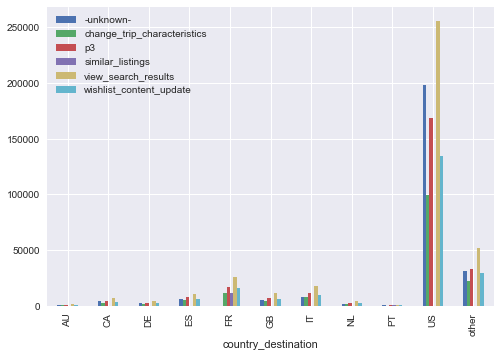

In [35]:
merge_df.groupby(['country_destination'])['action_detail'].apply(lambda x: x.value_counts().head(5)).unstack().plot(kind= 'bar')

In [36]:
merge_df[merge_df['action_detail']=='change_trip_characteristics']['country_destination'].value_counts()

US       99142
other    21948
FR       11727
IT        7668
ES        5061
GB        4290
CA        2552
DE        1794
NL        1587
AU         829
PT         453
Name: country_destination, dtype: int64

## 統計檢驗

In [37]:
from scipy import stats

### 性別對國家影響

In [38]:
def chi2_test(contingency_table, alpha= 0.05):
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    
    print(f'chi^2 : {chi2}')
    print(f'degree of freedom : {dof}')
    
    n = contingency_table.to_numpy().sum()
    n_row, n_col = contingency_table.shape 
    cramers_v = np.sqrt(chi2/(n*(min(n_row, n_col) - 1)))
    
    if p < alpha:
        print(f'reject H0：\np value= {p}')
    else: 
        print(f'do not reject H0：\np value= {p}')
        
    print(f'cramers_v : {cramers_v.round(2)}')

In [39]:
contingency = pd.crosstab(index= new_df['gender'], columns= new_df['country_destination'])

In [40]:
contingency.drop(contingency.index[[0,3]], inplace=True)

In [41]:
chi2_test(contingency)

chi^2 : 214.26882956350897
degree of freedom : 10
reject H0：
p value= 1.6903821526166418e-40
cramers_v : 0.06


### 語言對國家影響

In [42]:
contingency = pd.crosstab(index= new_df['language'], columns= new_df['country_destination'])

In [43]:
contingency.head(5)

country_destination,AU,CA,DE,ES,FR,GB,IT,NL,PT,US,other
language,,,,,,,,,,,
ca,0,0,0,0,0,0,0,0,0,2,0
cs,0,0,0,1,0,0,0,0,0,6,2
da,0,0,0,2,0,0,1,0,0,14,2
de,3,1,24,7,10,5,6,2,1,193,18
el,0,0,0,2,1,0,0,0,0,2,1


In [44]:
chi2_test(contingency)

chi^2 : 724.6838071905186
degree of freedom : 220
reject H0：
p value= 3.766966078892133e-55
cramers_v : 0.03


### 年齡對國家影響

In [45]:
contingency = pd.crosstab(index= new_df['age_bin'], columns= new_df['country_destination'])

In [46]:
contingency

country_destination,AU,CA,DE,ES,FR,GB,IT,NL,PT,US,other
age_bin,,,,,,,,,,,
0-30,149,341,305,695,1205,573,712,229,61,17769,2642
30-60,262,672,486,915,2256,1049,1168,326,89,28124,4459
60-100,25,64,60,96,252,152,156,47,8,2710,475


In [47]:
chi2_test(contingency)

chi^2 : 116.04397722426503
degree of freedom : 20
reject H0：
p value= 1.533175387896118e-15
cramers_v : 0.03


### Signup_method 對國家影響

In [48]:
contingency = pd.crosstab(index= new_df['signup_method'], columns= new_df['country_destination'])

In [49]:
contingency.drop(contingency.index[[2]], inplace= True)

In [50]:
contingency

country_destination,AU,CA,DE,ES,FR,GB,IT,NL,PT,US,other
signup_method,,,,,,,,,,,
basic,393,1105,737,1601,3767,1727,2147,560,154,45430,7430
facebook,146,322,323,646,1253,597,686,202,62,16867,2652


In [51]:
chi2_test(contingency)

chi^2 : 48.529098330938574
degree of freedom : 10
reject H0：
p value= 4.967768526593509e-07
cramers_v : 0.02


### 年份對國家影響

In [52]:
new_df['year'] = new_df['date_first_booking'].apply(lambda x: x.split('-')[0])
new_df['month'] = new_df['date_first_booking'].apply(lambda x: x.split('-')[1])

In [53]:
contingency= pd.crosstab(index= new_df['year'], columns= new_df['country_destination'])

In [54]:
contingency.drop(contingency.index[[0,-1]], inplace=True)

In [55]:
contingency

country_destination,AU,CA,DE,ES,FR,GB,IT,NL,PT,US,other
year,,,,,,,,,,,
2011,32,116,89,174,420,147,177,60,17,4023,483
2012,95,269,264,441,1026,483,546,142,33,11219,1723
2013,216,476,388,771,1784,828,961,269,74,22011,3481
2014,179,509,298,806,1607,802,1090,269,87,22632,4140


In [56]:
chi2_test(contingency)

chi^2 : 273.93577447316915
degree of freedom : 30
reject H0：
p value= 3.4220695184701245e-41
cramers_v : 0.03


In [57]:
contingency= pd.crosstab(index= new_df['affiliate_channel'], columns= new_df['country_destination'])

In [58]:
contingency.drop(contingency.index[[0,1,3,4]],inplace=True)

In [59]:
contingency

country_destination,AU,CA,DE,ES,FR,GB,IT,NL,PT,US,other
affiliate_channel,,,,,,,,,,,
direct,363,945,699,1536,3294,1579,1858,503,144,41725,6752
sem-brand,65,154,137,278,669,329,463,103,37,7725,1134
sem-non-brand,59,147,112,180,533,193,242,80,17,4552,1035
seo,17,58,46,118,233,99,121,34,8,2729,492


In [60]:
chi2_test(contingency)

chi^2 : 232.08907032821926
degree of freedom : 30
reject H0：
p value= 4.1889007153363664e-33
cramers_v : 0.03


----

## Model 

In [61]:
from sklearn.feature_selection import RFE, RFECV, SelectKBest, chi2
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
import copy 
import xgboost as xgb

In [62]:
new_df.head(3)

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,age_clean,age_bin,year,month
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,56.0,30-60,2010,08
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,42.0,30-60,2012,09
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,41.0,30-60,2010,02


In [63]:
test_df.head(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome


### Preprocessing
* XGBoost Only allows int, float, or boolean data types
* Converting it with to_numeric()

In [64]:
X = new_df.drop('country_destination', axis= 1).copy()

In [65]:
X.drop(['user_id', 'date_first_booking', 'age','date_account_created', 'timestamp_first_active'], axis= 1, inplace= True)

In [66]:
X.fillna(0, inplace=True)

In [67]:
X['year'] = pd.to_numeric(X['year'])
X['month'] = pd.to_numeric(X['month'])

In [68]:
X.head(3)

,gender,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,age_clean,age_bin,year,month
2,FEMALE,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,56.0,30-60,2010,8
3,FEMALE,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,42.0,30-60,2012,9
4,-unknown-,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,41.0,30-60,2010,2


In [69]:
y = new_df['country_destination'].copy()

In [70]:
assert len(X) == len(y), 'length is not matched'

### Encoding

In [71]:
obj_cols = X.select_dtypes(include=['object']).columns 

In [72]:
X_encoded = pd.get_dummies(X, columns=obj_cols)

In [73]:
# le = preprocessing.LabelEncoder()
# y = le.fit_transform(y)

### split
param：stratify = y 

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state= 42, stratify= y)

In [75]:
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

In [76]:
print(f'training size: {len(X_train)/(len(X_train)+len(X_test))}\ntesting size: {len(X_test)/(len(X_train)+len(X_test))}')

training size: 0.75
testing size: 0.25


### training 
* subsample：for each tree, how many percent of data used
* colsample_bytree：for each tree, how many percent of columns (reduce overfitting)

In [77]:
clf = xgb.XGBClassifier(objective='multi:softprob', 
                        missing= None, 
                        subsample= 0.5,
                        colsample_bytree= 0.5,
#                         scale_pos_weight= 3,
                        seed=42)

In [78]:
# clf.fit(X_train,
#        y_train,
#        verbose=True,
#        early_stopping_rounds=10,
#        eval_metric='mlogloss',
#        eval_set=[(X_test, y_test)])

In [79]:
# plot_confusion_matrix(clf,
#                       X_test,
#                       y_test,
#                       values_format= 'd')

### Imbalance Learn

In [80]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [81]:
smote = SMOTE()

In [82]:
X_train_smote, y_train_smote= smote.fit_sample(X_train, y_train)

In [83]:
print(f'value counts before SMOTE: {Counter(y_train)}')
print(f'value counts after SMOTE: {Counter(y_train_smote)}')

value counts before SMOTE: Counter({'US': 46782, 'other': 7571, 'FR': 3767, 'IT': 2126, 'GB': 1743, 'ES': 1687, 'CA': 1071, 'DE': 796, 'NL': 571, 'AU': 404, 'PT': 163})
value counts after SMOTE: Counter({'US': 46782, 'IT': 46782, 'other': 46782, 'GB': 46782, 'DE': 46782, 'ES': 46782, 'FR': 46782, 'CA': 46782, 'PT': 46782, 'AU': 46782, 'NL': 46782})


In [84]:
clf.fit(X_train_smote,
       y_train_smote,
       verbose=True,
       early_stopping_rounds=5,
       eval_metric='mlogloss',
       eval_set=[(X_test, y_test)])

KeyboardInterrupt: 

In [ ]:
plot_confusion_matrix(clf,
                      X_test,
                      y_test,
                      values_format= 'd')

### Check Underfitting 

In [ ]:
y_pred = clf.predict(X_train_smote)

In [ ]:
print(classification_report(y_true= y_train_smote, y_pred=y_pred))

### Check overfitting

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(y_true= y_test, y_pred=y_pred))

## Test Data

In [96]:
test_df[test_df.date_first_booking.notnull()]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser


In [100]:
test_df.drop(columns=['date_first_booking'], inplace=True)

### 分類 NDF

In [178]:
train_df_copy = copy.deepcopy(train_df)

In [179]:
train_df_copy.drop(columns=['date_first_booking'], inplace= True)

#### 創帳和第一次接觸時間差

In [180]:
train_df_copy['timestamp_first_active'] = train_df_copy['timestamp_first_active'].apply(date_correct)

In [181]:
train_df_copy['date_account_created'] = train_df_copy['date_account_created'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

In [182]:
train_df_copy['day_lag']= train_df_copy['date_account_created'] - train_df_copy['timestamp_first_active']

In [183]:
train_df_copy['day_lag']= train_df_copy['day_lag'].apply(lambda x: x.days)

In [184]:
# train_df_copy[train_df_copy['day_lag']>0]['country_destination'].value_counts().plot(kind= 'bar')
# train_df_copy[train_df_copy['day_lag']==0]['country_destination'].value_counts().plot(kind= 'bar')

#### TARGET NDF Vs Non-NDF

In [185]:
train_df_copy.loc[train_df_copy['country_destination'] != 'NDF', 'country_destination'] = 'Non-NDF'

In [193]:
# train_df_copy

In [192]:
# train_df_copy[train_df_copy['day_lag']>0]['country_destination'].value_counts().plot(kind= 'bar')

In [191]:
# train_df_copy[train_df_copy['day_lag']==0]['country_destination'].value_counts().plot(kind= 'bar')